In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path_train=untar_data("http://imagenet.stanford.edu/internal/car196/cars_train");path_train

PosixPath('/home/jupyter/.fastai/data/cars_train')

In [5]:
path_train.ls()

[PosixPath('/home/jupyter/.fastai/data/cars_train/07650.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/06841.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/02382.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/04738.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/06361.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/05085.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/06533.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/04365.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/07980.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/04969.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/01592.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/00980.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/06915.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/05715.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/06341.jpg'),
 PosixPath('/home/jupyter/.fastai/data/cars_train/02620

In [4]:
label_path=untar_data("https://ai.stanford.edu/~jkrause/cars/car_devkit");label_path

PosixPath('/home/jupyter/.fastai/data/car_devkit')

In [5]:
## Not my code copied from https://gist.github.com/beeva-albertorincon/c2d9f7cc7a51a2d6506812d6f96a14ca
from scipy.io import loadmat
import pandas as pd
import numpy as np

label_path='/home/jupyter/.fastai/data/devkit'
img_path = '/home/jupyter/.fastai/data/car_train'
mat_train = loadmat(label_path+'/cars_train_annos.mat')

meta = loadmat(label_path+'/cars_meta.mat')

labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])
    
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = str(example[-1][0])
    train.append((image,label))

with open(label_path+'/cars_data.csv', 'w+') as f:
    [f.write('imgName,class\n')]
    [f.write('%s,%s\n' %(img,lab)) for img,lab in train]
    #[f.write('VALIDATION,%s,%s\n' %(img,lab)) for img,lab in validation]
    #[f.write('TEST,%s%s\n' %(img_path+'/',img)) for img,_ in test]

In [6]:
df=pd.read_csv(label_path+'/cars_data.csv',dtype=str)

In [7]:
df.head()

,imgName,class
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


In [8]:
df=df.dropna()

In [9]:
#doc(ImageDataBunch.from_df)

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.2)
#data=ImageDataBunch.from_df(path_train,df,ds_tfms=tfms,size=299)
data = (
    ImageList
    .from_df(df=df, path=path_train)
    .split_by_rand_pct(valid_pct=0.2, seed=1010) 
    .label_from_df(cols="class")
    .transform(tfms=get_transforms(), size=299, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16) # Batch Size adjusted according to GPU Memory Capacity
    .normalize(imagenet_stats) # Normalize Image according to ImageNet's Normalization because we are using ImageNet's pretrained model
)

In [10]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: /home/jupyter/.fastai/data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Nissan 240SX Coupe 1998,Audi S5 Convertible 2012,Chevrolet Sonic Sedan 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Mercedes-Benz S-Class Sedan 2012
Path: /home/jupyter/.fastai/data/cars_train;

Test: None

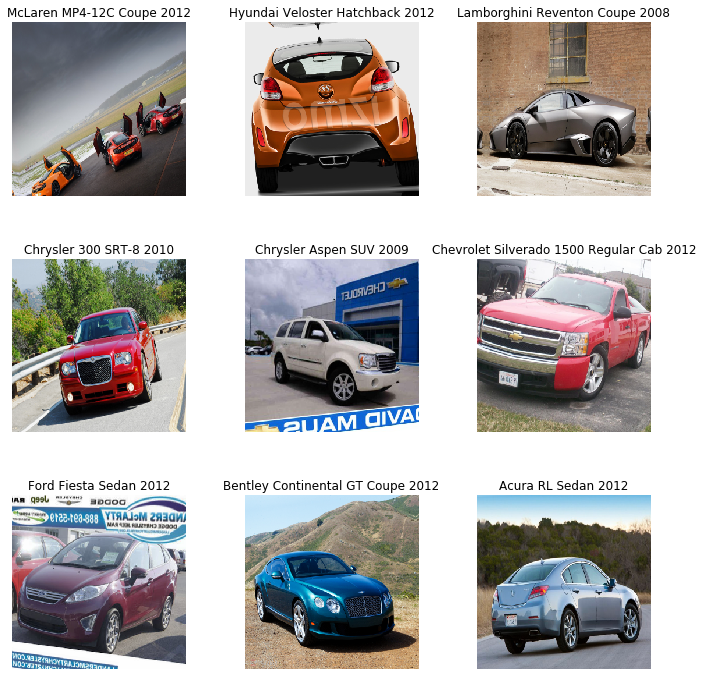

In [11]:
data.show_batch(rows=3, figsize=(10,10))

In [12]:
## Train model
learner=cnn_learner(data, models.resnet50, metrics=error_rate)

In [13]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,4.976134,3.791498,0.826781,02:24
1,3.518873,2.671179,0.650491,02:13
2,2.682710,1.894818,0.501229,02:14
3,1.952779,1.566016,0.396192,02:14
4,1.472425,1.291146,0.331695,02:14
5,1.054409,1.164448,0.305283,02:14
6,0.785760,1.077642,0.279484,02:14
7,0.662170,1.070064,0.273342,02:15


In [12]:
#lets see resnet 152 version 
learner=cnn_learner(data, models.resnet152, metrics=error_rate)

In [13]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,4.696792,3.483278,0.787469,04:50
1,3.188131,2.240805,0.565111,04:45
2,2.332509,1.576485,0.420147,04:45
3,1.669847,1.204167,0.322482,04:46
4,1.194637,1.003793,0.277641,04:45
5,0.804997,0.854875,0.239558,04:46
6,0.524143,0.822445,0.221744,04:46
7,0.468239,0.805527,0.223587,04:46


In [14]:
learner.save('stage-1')

In [15]:
interp = ClassificationInterpretation.from_learner(learner)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

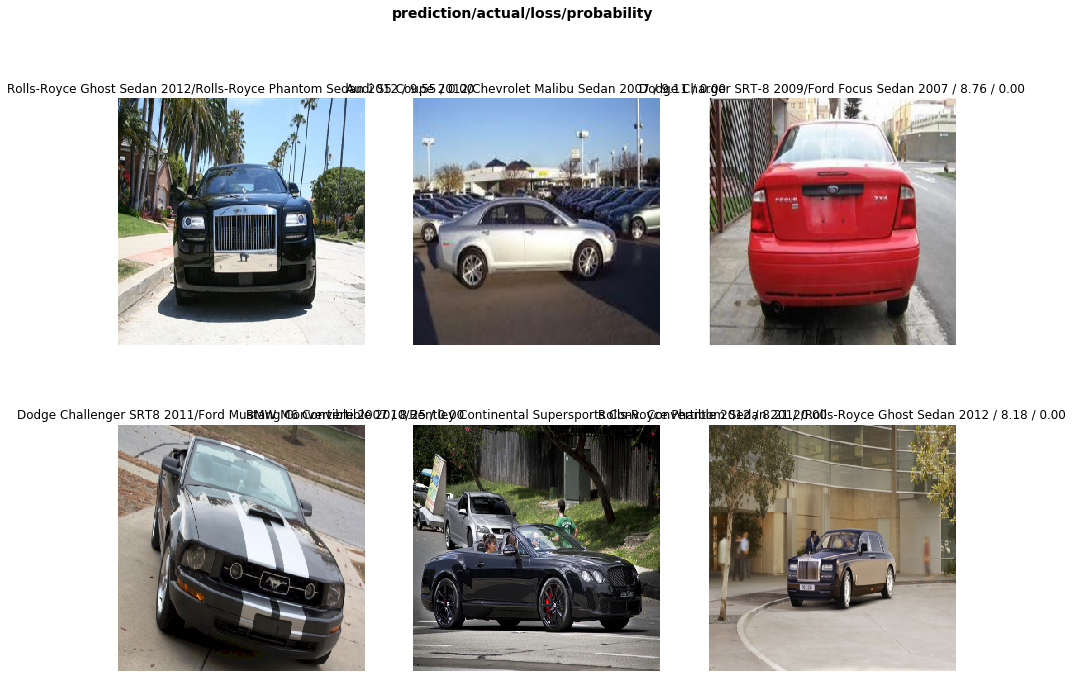

In [21]:
interp.plot_top_losses(6, figsize=(15,11))

In [16]:
interp.most_confused(min_val=2)

[('BMW M5 Sedan 2010', 'BMW 1 Series Coupe 2012', 4),
 ('Chevrolet Silverado 1500 Extended Cab 2012',
  'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  4),
 ('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 4),
 ('Bentley Continental GT Coupe 2012', 'Bentley Continental GT Coupe 2007', 3),
 ('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 3),
 ('GMC Yukon Hybrid SUV 2012', 'Chevrolet Tahoe Hybrid SUV 2012', 3),
 ('Jaguar XK XKR 2012', 'Fisker Karma Sedan 2012', 3),
 ('Jeep Wrangler SUV 2012', 'AM General Hummer SUV 2000', 3),
 ('Rolls-Royce Ghost Sedan 2012', 'Rolls-Royce Phantom Sedan 2012', 3),
 ('Spyker C8 Coupe 2009', 'Spyker C8 Convertible 2009', 3),
 ('Acura RL Sedan 2012', 'Acura TSX Sedan 2012', 2),
 ('Audi A5 Coupe 2012', 'Audi S5 Coupe 2012', 2),
 ('Audi RS 4 Convertible 2008', 'Audi S5 Convertible 2012', 2),
 ('Audi S5 Coupe 2012', 'Honda Accord Sedan 2012', 2),
 ('Audi TT Hatchback 2011', 'Audi TTS Coupe 2012', 2),
 ('Audi V8 Sedan 1994', 'Audi 100 Sedan 1

In [17]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


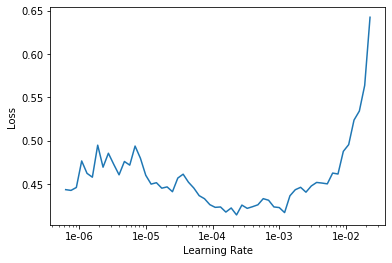

In [18]:
learner.recorder.plot()

In [21]:
learner.unfreeze()
learner.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.788561,0.993355,0.272113,06:18
1,0.794993,0.778780,0.207002,06:18
2,0.384207,0.534482,0.150491,06:19
3,0.167837,0.481671,0.140663,06:18


In [ ]:
#Reached around 86% accuracy after fine tuning 


# Acknowledgements


### https://gist.github.com/beeva-albertorincon/c2d9f7cc7a51a2d6506812d6f96a14ca
### https://github.com/jianshen92/stanford-car-grab-challenge/blob/master/Stanford%20Car%20Model%20Training.ipynb
### https://ai.stanford.edu/~jkrause/papers/3drr13.pdf